# Question 1

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/train_data',split='train',transform=transform,download=True)
testset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/test_data',split='test',transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=4)

print(len(trainloader))
print(len(testloader))

Files already downloaded and verified
Files already downloaded and verified
79
125


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
resnet50 = models.resnet50(pretrained=True)
layers=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*layers)
for params in resnet50.parameters():
    params.requires_grad = False
resnet50 = resnet50.cuda()

x_train_svm = []
y_train_svm = []

for idx,batch in enumerate(trainloader):
    images,lbls = batch
    images = images.cuda()
    lbls = lbls
    out = resnet50(images)
    for i in range(out.shape[0]):
      x_train_svm.append(out.detach().cpu().numpy()[i].flatten())
      y_train_svm.append(lbls[i])


x_test_svm = []
y_test_svm = []

for idx,batch in enumerate(testloader):
    images,lbls = batch
    images = images.cuda()
    lbls = lbls
    out = resnet50(images)
    for i in range(out.shape[0]):
      x_test_svm.append(out.detach().cpu().numpy()[i].flatten())
      y_test_svm.append(lbls[i])

np.save("/content/drive/MyDrive/STL_10/train_data_svm/x_train_svm.npy",np.array(x_train_svm))
np.save("/content/drive/MyDrive/STL_10/train_data_svm/y_train_svm.npy",np.array(y_train_svm))

np.save("/content/drive/MyDrive/STL_10/test_data_svm/x_test_svm.npy",np.array(x_test_svm))
np.save("/content/drive/MyDrive/STL_10/test_data_svm/y_test_svm.npy",np.array(y_test_svm))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
x_train = np.load("/content/drive/MyDrive/STL_10/train_data_svm/x_train_svm.npy")
x_test = np.load("/content/drive/MyDrive/STL_10/test_data_svm/x_test_svm.npy")
y_train_nums = np.load("/content/drive/MyDrive/STL_10/train_data_svm/y_train_svm.npy")
y_test_nums = np.load("/content/drive/MyDrive/STL_10/test_data_svm/y_test_svm.npy")

print(x_train.shape)
print(y_train_nums.shape)
print(x_test.shape)
print(y_test_nums.shape)

y_train = label_binarize(y_train_nums, classes=np.unique(y_train_nums))
y_test = label_binarize(y_test_nums, classes=np.unique(y_train_nums))


def calibrated(x_train, x_test, y_train,c=1.0):
  model = OneVsRestClassifier(svm.SVC(kernel='rbf'))
  model.fit(x_train, y_train)
  file1 = "/content/drive/MyDrive/STL_10/svm_model.pkl"
  pickle.dump(model,open(file1,'wb'))

  return model.decision_function(x_test)

y_pred_test_scores = calibrated(x_train, x_test, y_train)
y_pred_test = np.argmax(y_pred_test_scores,axis=1)

accuracy_test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_test_scores,axis=1)) * 100
print('\nTest accuracy_score:',accuracy_test)


def Confusion_Matrix(y_true,y_pred_test_scores,n_classes):
  y_t = np.argmax(y_true,axis=1)
  y_p = np.argmax(y_pred_test_scores,axis=1)
  
  confusion_mat = np.zeros((n_classes,n_classes))
  
  for i in range(n_classes):
    for j in range(n_classes):
      confusion_mat[i][j] = len(np.where(y_p[np.where(y_t==i)]==j)[0])

  return confusion_mat

print("\n Confusion Matrix")
print(Confusion_Matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_test_scores,axis=1)))


(5000, 2048)
(5000,)
(8000, 2048)
(8000,)

Test accuracy_score: 83.65

 Confusion Matrix
[[679  12  12   0   4   1   2   2  69  19]
 [ 10 709   1  24  12   6   3  32   2   1]
 [  9   0 719   0   3   1   1   1   3  63]
 [  3  15   3 586  60  62  11  49   5   6]
 [  4  21   0  34 663  20  42  13   2   1]
 [  5  20   2  38  23 624  62  21   4   1]
 [  8   3   5   7  48  36 669  14   3   7]
 [  1  23   3  34  41  14  15 664   4   1]
 [ 38   1   3   2   0   0   3   0 710  43]
 [ 20   0  39   3   2   1   7   7  52 669]]


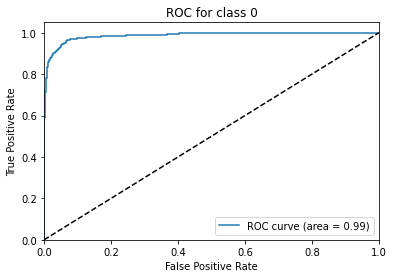

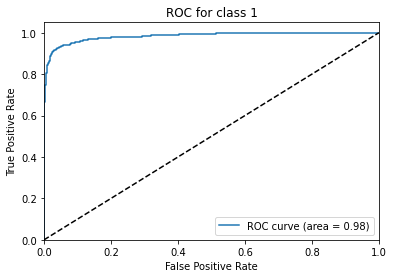

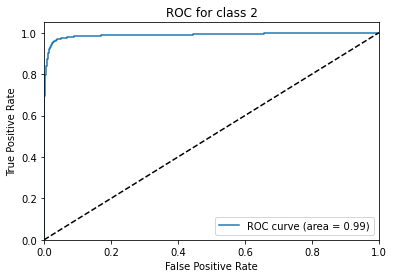

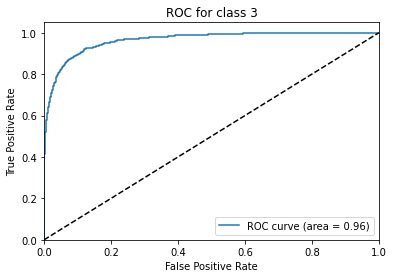

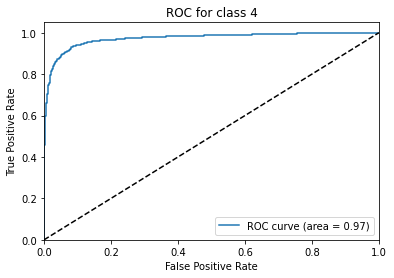

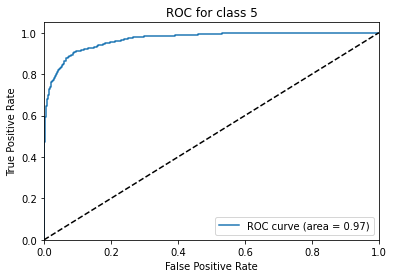

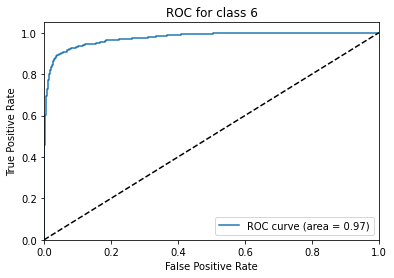

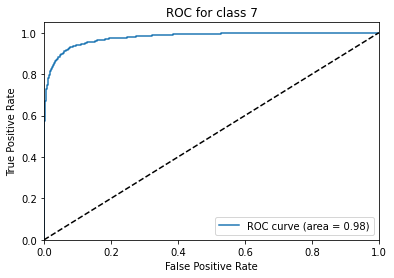

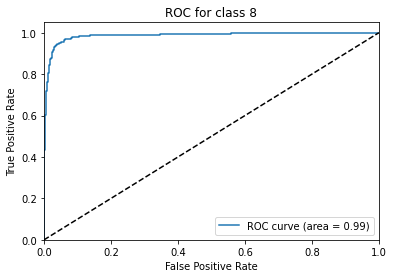

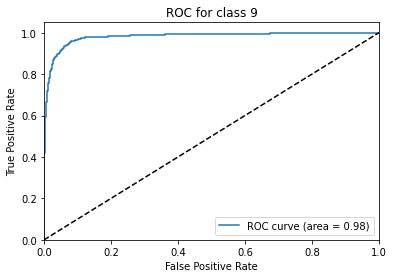

In [ ]:
def tp_fp_tn_fn(y_pred_test_scores,y_true,th=None):

    y_test = np.argmax(y_true,axis=1)
    y_pred = np.argmax(y_pred_test_scores,axis=1)

    TP =0
    FP =0
    FN =0
    TN =0

    for i in range(len(y_pred)):
        
        if y_pred[i] == 1 and y_test[i] == 1:
            TP += 1

        elif y_pred[i] == 1 and y_test[i] == 0:
            FP += 1
        
        elif y_pred[i] == 0 and y_test[i] == 1:
            FN += 1
        
        elif y_pred[i] == 0 and y_test[i] == 0:
            TN += 1

        try: 
            TPR = TP / (TP+FN) 
            FPR = FP / (FP+TN)


        except:
    
            TPR = 0.0
            FPR = 0.0

        
    return FPR,TPR

def Roc_Curve(test_labels,y_pred_test_score):

    thresold_FPR_TPR  = []
    fprs = []
    tprs = []

    thresholds = np.linspace(0,1,1000)
    for th in thresholds:
        list1 = []
        for i in range(len(test_labels)):
            if y_pred_test_score[i][1] >= th:
                list1.append(1)
            else:
                list1.append(0)

            
        FPR,TPR  = tp_fp_tn_fn(np.array(list1),test_labels,th)
        thresold_FPR_TPR.append([th,FPR,TPR])
        fprs.append(FPR)
        tprs.append(TPR)

    return fprs,tprs


fpr = dict()
tpr = dict()
roc_auc = dict()
classes = np.unique(y_train_nums)
n_classes = len(classes)

for i in range(n_classes):
    fpr[i], tpr[i] = Roc_Curve(y_test[:,i], y_pred_test_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for class '+str(i))
    plt.legend(loc="lower right")
    plt.show()

#Finetuning resnet50

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/train_data',split='train',transform=transform,download=False)
testset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/test_data',split='test',transform=transform,download=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

print(len(trainloader))
print(len(testloader))

79
125


In [ ]:
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
def test(dataloader,model,criterion,purpose="test"):
    batch_size=64
    with torch.no_grad():
        test_loss = 0.0
        test_correct = 0
        for idx,batch in enumerate(dataloader):
            imgs,lbls = batch
            imgs = imgs.float()
            lbls = lbls.long()
            
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            out = model(imgs)
            loss = criterion(out,lbls)

            test_loss += loss.item()
                
            test_pred = torch.argmax(out, dim=1)
            test_correct += torch.sum(test_pred == lbls)
            
        test_loss = test_loss/float(len(dataloader))
        test_acc = float(float(test_correct)/float(len(dataloader)*batch_size))

        if purpose == "test": 
            for idx,batch in enumerate(dataloader):
              imgs,lbls = batch
              imgs = imgs.float().to(device)
              out = model(imgs)
              test_pred = torch.argmax(out, dim=1)
              for i in range(10):
                img = imgs[i]
                actual_lbl = lbls[i].detach().cpu().numpy()
                pred_lbl = test_pred[i].detach().cpu().numpy()

                img_disp = img.permute(1,2,0).detach().cpu().numpy()
                actual_lbl_disp = actual_lbl
                pred_lbl_disp = pred_lbl
                print("actual_label:",class_names[actual_lbl_disp],"predicted_label:",class_names[pred_lbl_disp])
                plt.imshow(img_disp)
                plt.show()
              break
                        
            
    
    return test_loss,test_acc

In [ ]:
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 10) 

ct=0
for child in resnet50.children():
  ct += 1
  if ct < 6:      
      for params in child.parameters():
          params.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

cuda


100%|██████████| 79/79 [00:28<00:00,  2.74it/s, batch_loss=1.2371525764465332]



epoch: 0  Train Loss: 1.7450923587702498  Train Accuracy: 0.49030854430379744


100%|██████████| 79/79 [00:28<00:00,  2.78it/s, batch_loss=0.9321160912513733]



epoch: 1  Train Loss: 0.820102005065242  Train Accuracy: 0.8475079113924051


100%|██████████| 79/79 [00:28<00:00,  2.80it/s, batch_loss=0.6891837120056152]



epoch: 2  Train Loss: 0.41477047284192675  Train Accuracy: 0.910996835443038


100%|██████████| 79/79 [00:28<00:00,  2.81it/s, batch_loss=0.5156435966491699]



epoch: 3  Train Loss: 0.23985053183911723  Train Accuracy: 0.9432357594936709


100%|██████████| 79/79 [00:28<00:00,  2.80it/s, batch_loss=0.391012966632843]



epoch: 4  Train Loss: 0.1446739748780486  Train Accuracy: 0.966376582278481


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: horse predicted_label: horse


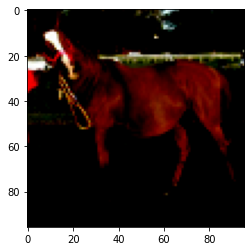

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: dog predicted_label: dog


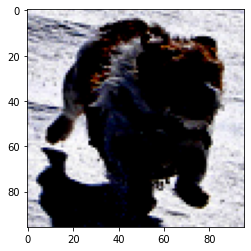

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: ship predicted_label: ship


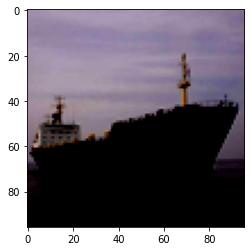

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: monkey predicted_label: monkey


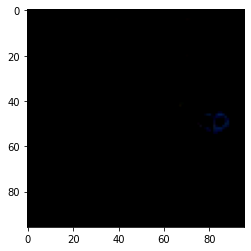

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: truck predicted_label: truck


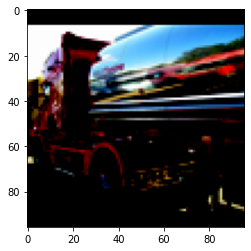

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actual_label: ship predicted_label: ship


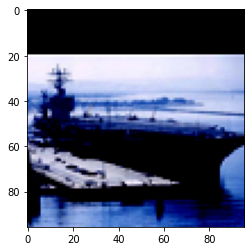

actual_label: monkey predicted_label: monkey


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


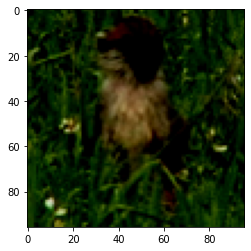

actual_label: horse predicted_label: horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


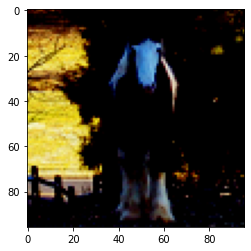

actual_label: cat predicted_label: deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


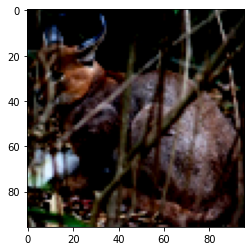

actual_label: cat predicted_label: cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


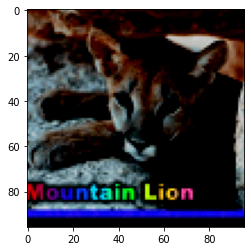


 test accuracy: 91.55 %


In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


train_loss = []
validation_loss = []
train_acc = [] 
validation_acc = []

num_epochs = 5
learning_rate = 0.00001

batch_size=64
model = resnet50.to(device)
model.train()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)

for epoch in range(num_epochs):
  running_loss = 0.0
  running_correct = 0
  model.train()
  with tqdm(total=len(trainloader)) as pbar:  
    for idx,batch in enumerate(trainloader):
      imgs,lbls = batch
      imgs = imgs.float()
      lbls = lbls.long()
      
      imgs = imgs.to(device)
      lbls = lbls.to(device)

      optimizer.zero_grad()

      out = model(imgs)
      loss = criterion(out,lbls)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      num_correct = torch.sum(torch.argmax(out, dim=1) == lbls).item()

      running_correct += num_correct

      pbar.set_postfix(batch_loss='{}'.format(loss.item()))
      pbar.update(1)      
  
  
  train_loss.append(running_loss/float(len(trainloader)))
  train_acc.append(running_correct/float(len(trainloader)*batch_size))


  print("\nepoch:",epoch," Train Loss:",running_loss/float(len(trainloader))," Train Accuracy:",running_correct/float(len(trainloader)*batch_size))



model.eval()
test_loss,test_acc = test(testloader,model,criterion,purpose="test")
print("\n test accuracy:",test_acc*100,"%")


In [ ]:
y_pred = []
y_true = []
class_names_stl10 = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

for idx,batch in enumerate(testloader):
  imgs,lbls = batch
  imgs = imgs.float()
  lbls = lbls
  imgs = imgs.to(device)
  lbls = lbls.to(device)
  
  out = model(imgs)

  out_np = torch.argmax(out, dim=1).detach().cpu().numpy()
  lbls_np = lbls.detach().cpu().numpy()
  
  for i in range(len(lbls_np)):
    y_pred.append(out_np[i])
    y_true.append(lbls_np[i])


y_true = np.array(y_true)
y_pred = np.array(y_pred)

def Confusion_Matrix(y_true,y_pred,n_classes):

  y_t = y_true
  y_p = y_pred

  confusion_mat = np.zeros((n_classes,n_classes))
  
  for i in range(n_classes):
    for j in range(n_classes):
      confusion_mat[i][j] = len(np.where(y_p[np.where(y_t==i)]==j)[0])

  return confusion_mat

print("\nConfusion Matrix\n")
confus_matrix = Confusion_Matrix(y_true,y_pred,len(class_names_stl10))
print(confus_matrix)

def class_wise_accuracy(confus_matrix):

  class_accuracy = []
  class_TP = []

  for i in range(confus_matrix.shape[0]):
    for j in range(confus_matrix.shape[1]):
      if i == j:
        TP = confus_matrix[i][j]
        class_TP.append(TP)
        
  for k in range(confus_matrix.shape[1]):
    ca = (class_TP[k] / confus_matrix[:,k].sum())*100
    class_accuracy.append(ca)
    print("class ",k," accuracy ",class_names_stl10[k]," :",ca,"%")    
    
  class_accuracy = np.array(class_accuracy)

print('\nClass-wise Accuracy\n')            
class_wise_accuracy(confus_matrix)



Confusion Matrix

[[737.   5.   5.   0.   0.   0.   0.   1.  37.  15.]
 [  2. 755.   0.  18.   3.   4.   2.  16.   0.   0.]
 [  4.   0. 750.   0.   0.   0.   1.   0.   2.  43.]
 [  1.   6.   0. 682.  32.  41.   3.  34.   1.   0.]
 [  0.  12.   0.  22. 735.  11.  17.   3.   0.   0.]
 [  1.   3.   0.  45.  16. 673.  33.  28.   1.   0.]
 [  1.   3.   0.   4.  33.  37. 710.   7.   1.   4.]
 [  0.   9.   0.  10.  13.   9.   3. 755.   1.   0.]
 [  9.   0.   0.   0.   0.   0.   0.   0. 769.  22.]
 [  5.   0.  17.   0.   0.   0.   0.   1.  19. 758.]]

Class-wise Accuracy

class  0  accuracy  airplane  : 96.97368421052632 %
class  1  accuracy  bird  : 95.20807061790669 %
class  2  accuracy  car  : 97.15025906735751 %
class  3  accuracy  cat  : 87.32394366197182 %
class  4  accuracy  deer  : 88.34134615384616 %
class  5  accuracy  dog  : 86.83870967741936 %
class  6  accuracy  horse  : 92.32769830949285 %
class  7  accuracy  monkey  : 89.3491124260355 %
class  8  accuracy  ship  : 92.5391095066

**Normal Resnet50 (Not finetuned)**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/train_data',split='train',transform=transform,download=True)
testset = torchvision.datasets.STL10(root='/content/drive/MyDrive/STL_10/test_data',split='test',transform=transform,download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=4)

print(len(trainloader))
print(len(testloader))

Files already downloaded and verified
Files already downloaded and verified
79
125


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class_names_stl10 = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
common_classes = {726:'airplane',895:'airplane',14:'bird',94:'bird',134:'bird',705:'car',751:'car',817:'car',281:'cat',282:'cat',283:'cat',284:'cat',285:'cat',383:'cat',177:'deer', 153:'dog',153:'dog',200:'dog',235:'dog',238:'dog',239:'dog',245:'dog',248:'dog',251:'dog',252:'dog',254:'dog',256:'dog',275:'dog',603:'horse',370:'monkey',371:'monkey',375:'monkey',376:'monkey',379:'monkey',380:'monkey',381:'monkey',382:'monkey',510:'ship',724:'ship', 555:'truck',569:'truck',717:'truck',864:'truck',867:'truck'}

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

resnet50 = models.resnet50(pretrained=True)

model = resnet50.to(device)
resnet50.eval()

all_predictions = []
all_labels = []
all_name_labels = []
all_name_predictions = []

for idx,batch in enumerate(testloader):
  imgs,lbls = batch
  imgs = imgs.float()
  lbls = lbls.long()
  
  imgs = imgs.to(device)
  lbls = lbls.to(device)
  out = model(imgs)

  test_pred = torch.argmax(out, dim=1)
  
  detached_test_pred = test_pred.detach().cpu().numpy() 
  detached_labels = lbls.detach().cpu().numpy()
  for i in range(len(detached_test_pred)):
    all_predictions.append(detached_test_pred[i])
    all_labels.append(detached_labels[i])

correct_classified_classes = 0
other=0

for index in range(len(all_predictions)):
  if all_predictions[index] in list(common_classes.keys()):
    all_name_predictions.append(common_classes[all_predictions[index]])
    all_name_labels.append(class_names_stl10[all_labels[index]])
    
  else:
    all_name_predictions.append('z_other')
    all_name_labels.append(class_names_stl10[all_labels[index]])
    other+=1


class_names_stl10_with_other = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','z_other']

le = preprocessing.LabelEncoder()
le.fit(class_names_stl10_with_other)
y_pred = le.transform(all_name_predictions)
y_true = le.transform(all_name_labels)

for i in range(len(y_pred)):
  if y_pred[i] == y_true[i]:
    correct_classified_classes+=1

test_acc = correct_classified_classes/len(all_predictions)
print("\n test accuracy:",test_acc*100,"%")

cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



 test accuracy: 20.75 %


In [ ]:
from sklearn import preprocessing

def Confusion_Matrix(y_true,y_pred,n_classes):

  y_t = y_true
  y_p = y_pred

  confusion_mat = np.zeros((n_classes,n_classes))
  
  for i in range(n_classes):
    for j in range(n_classes):
      confusion_mat[i][j] = len(np.where(y_p[np.where(y_t==i)]==j)[0])

  return confusion_mat


print("\nConfusion Matrix\n")
confus_matrix = Confusion_Matrix(y_true,y_pred,len(class_names_stl10_with_other))
print(confus_matrix)

def class_wise_accuracy(confus_matrix):
  class_names_stl10_with_other = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','z_other']

  class_accuracy = []
  class_TP = []

  for i in range(confus_matrix.shape[0]):
    for j in range(confus_matrix.shape[1]):
      if i == j:
        TP = confus_matrix[i][j]
        class_TP.append(TP)
        
  for k in range(confus_matrix.shape[1]):
    ca = (class_TP[k] / confus_matrix[:,k].sum())*100
    class_accuracy.append(ca)
    print("class ",k," accuracy ",class_names_stl10_with_other[k]," :",ca,"%")    
    
  class_accuracy = np.array(class_accuracy)

print('\nClass-wise Accuracy\n')            
class_wise_accuracy(confus_matrix)


Confusion Matrix

[[156.   0.   1.   0.   0.   0.   0.   0.   4.   0. 639.]
 [  0.  33.   0.   2.   0.   0.   0.   2.   0.   0. 763.]
 [  2.   0. 177.   0.   0.   0.   0.   0.   0.  56. 565.]
 [  0.   0.   0. 237.   0.   1.   0.   2.   0.   0. 560.]
 [  0.   1.   0.   1.   0.   1.   1.   1.   0.   0. 795.]
 [  1.   0.   0.   5.  11.  19.   1.   1.   0.   0. 762.]
 [  0.   1.   0.   0.   0.   4. 182.   0.   0.   2. 611.]
 [  0.   0.   0.   3.   0.   1.   0. 259.   0.   0. 537.]
 [  1.   0.   0.   0.   0.   0.   0.   0. 233.   1. 565.]
 [  1.   0.   5.   0.   0.   0.   4.   0.  53. 364. 373.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]

Class-wise Accuracy

class  0  accuracy  airplane  : 96.8944099378882 %
class  1  accuracy  bird  : 94.28571428571428 %
class  2  accuracy  car  : 96.72131147540983 %
class  3  accuracy  cat  : 95.56451612903226 %
class  4  accuracy  deer  : 0.0 %
class  5  accuracy  dog  : 73.07692307692307 %
class  6  accuracy  horse  : 96.80851063829788